In [ ]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import Callback
from lightning.pytorch import loggers as pl_loggers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from models import LitAE, LitPredictor
from models import L1Loss
from utils import LitDataModule, VisCallbackAE, save_code_cfg, get_dataloader

import numpy as np
from hydra import compose, initialize
from omegaconf import OmegaConf
from matplotlib import pyplot as plt
from math import ceil

initialize(config_path="./configs")
cfg = compose(config_name="config_DMBN_VFP_NPVP-S")
cfg.Env.strategy = 'dp'

pl.seed_everything(cfg.Env.rand_seed, workers=True)

In [111]:
def plot_model_result(pred_list, fig_name, num_frames, n = 2):
    fig, axes = plt.subplots(len(pred_list), num_frames, figsize = (num_frames, len(pred_list)))
    fig.subplots_adjust(wspace=0., hspace = 0.)

    for ax, pred in zip(axes, pred_list):
        for j in range(num_frames):
            ax[j].set_axis_off()
            
            img = pred[:, j, :, :, :].clone()
            img = renorm_transform(img) # type: ignore
            img = torch.clamp(img, min = 0., max = 1.)
            img = img[n, ...]

            img = transforms.ToPILImage()(img)
            ax[j].imshow(img) #, cmap = 'gray')
    #fig.savefig(f'{fig_name}.pdf', bbox_inches = 'tight')

class SlidingWindowManager():
    def __init__(self, to_list, tp_list, predictor):
        
        self.win_size = predictor.max_T
        self.stride = self.win_size // 2
        self.full_len = max(torch.max(to_list), torch.max(tp_list))+1 # assume all frames are queried for or observed
        self.num_windows = ceil(self.full_len / self.stride) - 1

    def get_window(self, full_frame, to_list, tp_list, prev_win_tp_list, window_idx, pred=None):
        start_time = window_idx * self.stride

        def win_t(t, offset=0,window_idx=window_idx):
            o_start_time = start_time + offset * self.stride
            end_time = min(o_start_time + self.win_size, self.full_len)

            return t[(t >= o_start_time) & (t < end_time)].to(torch.float32)

        win_to_list = win_t(to_list)
        win_tp_list = win_t(tp_list)

        if window_idx > 0 and pred is not None:
            # the new observations are the predictions from the previous window
            # plus any observation in the current window
            #prev_tp_list = win_t(tp_list, -1)

            full_frame[:, prev_win_tp_list.to(torch.long), ...] = pred # update the full frame with the predictions
            
            prev_win_tp_list = win_t(prev_win_tp_list)

            win_tp_list = torch.as_tensor(sorted(list(set(win_tp_list.tolist()) - (set(prev_win_tp_list.tolist())))))

            print(f'prev_win_tp_list: {prev_win_tp_list}')

            win_to_list = torch.as_tensor(sorted(list(set(torch.cat((win_to_list, prev_win_tp_list), dim=0).tolist()))))

        
        p = full_frame[:, win_to_list.to(torch.long), ...] # can contain observations and previous predictions (considered as new observations)
        
        print(f'win_to_list: {win_to_list}, win_tp_list: {win_tp_list}')


        return win_to_list-start_time, win_tp_list-start_time, p, win_tp_list

def inference(sample, to_list, tp_list, predictor, gray_scale = True, invert_window = False):

    # TODO: if the test sequence is longer than the training one use the sliding window to reinsert generated
    # frames as the observations of the next window

    p, f = sample
    full_frame = torch.cat([p, f], dim = 1).to(predictor.device)

    p = full_frame[:, to_list.to(torch.long), ...].detach().clone()
    try:
        f = full_frame[:, tp_list.to(torch.long), ...].detach().clone()
    except:
        f = None

    SWManager = SlidingWindowManager(to_list, tp_list, predictor)

    print(f"{SWManager.num_windows=} {SWManager.win_size=} {SWManager.stride=} {SWManager.full_len=}")

    predictor = predictor.eval()
    last_pred = None
    pred = torch.as_tensor([], device=predictor.device)
    prev_w_tp_list = None

    idxs = reversed(range(SWManager.num_windows)) if invert_window else range(SWManager.num_windows)

    for i in idxs:
        w_to_list, w_tp_list, obs, prev_w_tp_list = SWManager.get_window(full_frame, to_list, tp_list, prev_w_tp_list, i, last_pred)
        predictor.predictor.reset_pos_coor(w_to_list, w_tp_list)
        with torch.no_grad():
            rec_past_frames, rec_future_frames, last_pred = predictor(obs.clone())
        pred = torch.cat([pred, last_pred], dim = 1)

    # NOTE: p contains only the observations at the original to_list indices,
    # not also the one added by the sliding window

    print("=======")
        
    return p, f, pred

In [ ]:
train_loader, val_loader, test_loader, renorm_transform = get_dataloader('DMBN', 2,'data/dmbn', test_past_frames = 10, test_future_frames = 10, num_workers = 1, KTH_actions = ['handwaving'])
cfg.Predictor.resume_AE_ckpt = './NPVP_ckpts/DMBN_ResnetAE-WRONG/AE-epoch=499.ckpt'
predictor = LitPredictor.load_from_checkpoint('./NPVP_ckpts/DMBN_Predictor_VFP_NPVP-S-WRONG/Predictor-epoch=449.ckpt', cfg=cfg).to('cuda:0')

## Peform different task by a unified model
#### to_list denotes the temporal coordinates for observed frames.
#### tp_list denotes the temporal coordinates for target frames.
!! The maximum coordinate = num_past_frames+num_future_frames - 1   (see the configuration file for num_past_frames and num_future_frames)

In [112]:
rand_sample_num = None

gt_list         = []
vfp_list        = []
vpe_list        = []
vfi_list        = []
vrc_list        = []
vrc_hfps_list   = []

max_len = 5

for idx, sample in enumerate(test_loader):
    predictor = predictor.eval()


    with torch.no_grad():
        #VFP
        #to_list = torch.from_numpy(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])).to(torch.float32)
        #tp_list = torch.from_numpy(np.array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])).to(torch.float32)
        to_list = torch.from_numpy(np.array([0, 1, 2, 3, 4, 5]))
        tp_list = torch.from_numpy(np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]))
        c_vfp, t_vfp, vfp = inference(sample, to_list, tp_list, predictor, rand_sample_num)
        vfp_example = torch.cat([c_vfp, vfp], dim = 1)
        vfp_list.append(vfp_example)
        gt = torch.cat([c_vfp, t_vfp], dim=1)
        gt_list.append(gt)
        
        #VPE
        # tp_list = torch.from_numpy(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])).to(torch.float32)
        # to_list = torch.from_numpy(np.array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])).to(torch.float32)
        to_list = torch.from_numpy(np.array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]))
        tp_list = torch.from_numpy(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
        c_vpe, t_vpe, vpe = inference(sample, to_list, tp_list, predictor, rand_sample_num, invert_window=True)
        vpe_example = torch.cat([vpe, c_vpe], dim = 1)
        vpe_list.append(vpe_example)
        
        #VFI
        # to_list = torch.from_numpy(np.array([0, 1, 2, 3, 4, 5, 14, 15, 16, 17, 18, 19])).to(torch.float32)
        # tp_list = torch.from_numpy(np.array([6, 7, 8, 9, 10, 11, 12, 13])).to(torch.float32)
        to_list = torch.from_numpy(np.array([0, 1, 2, 3, 8, 9, 10, 11, 12, 13, 18, 19]))
        tp_list = torch.from_numpy(np.array([4, 5, 6, 7, 14, 15, 16, 17]))
        c_vfi, t_vfi, vfi = inference(sample, to_list, tp_list, predictor, rand_sample_num)
        vfi_example = torch.zeros_like(gt)
        vfi_example[:, to_list.to(torch.long), ...] = c_vfi
        vfi_example[:, tp_list.to(torch.long), ...] = vfi
        vfi_list.append(vfi_example)

        #video Random completion
        # to_list = torch.from_numpy(np.array([0, 1, 2, 3, 6, 7, 10, 14, 15, 16])).to(torch.float32)
        # tp_list = torch.from_numpy(np.array([4, 5, 8, 9, 11, 12, 13, 17, 18, 19])).to(torch.float32)
        to_list = torch.from_numpy(np.array([0, 1, 2, 5, 7, 9, 10, 12, 13, 15, 18, 19]))
        tp_list = torch.from_numpy(np.array([3, 4, 6, 8, 11, 14, 16, 17]))
        c_vrc, t_vrc, vrc = inference(sample, to_list, tp_list, predictor, rand_sample_num)
        vrc_example = torch.zeros_like(gt)
        vrc_example[:, to_list.to(torch.long), ...] = c_vrc
        vrc_example[:, tp_list.to(torch.long), ...] = vrc
        vrc_list.append(vrc_example)
        
        #high fps random completion
        to_list = torch.from_numpy(np.array([0, 1, 2, 3, 6, 7, 10, 11, 13, 16])).to(torch.float32)
        tp_list = torch.from_numpy(np.array([4, 4.25, 4.5, 5, 5.25, 5.5, 5.75, 8, 8.5, 9, 9.5, 11, 11.5, 12, 13.5, 15.5, 19.5])).to(torch.float32)
        c_vrc, t_vrc, vrc_hfps = inference(sample, to_list, tp_list, predictor, rand_sample_num)
        vrc_hfps_list.append(vrc_hfps)
        
    if idx+1 >= max_len: break

gt_list         = torch.stack(gt_list, dim = 0)
vfp_list        = torch.stack(vfp_list, dim = 0)
vpe_list        = torch.stack(vpe_list, dim = 0)
vfi_list        = torch.stack(vfi_list, dim = 0)
vrc_list        = torch.stack(vrc_list, dim = 0)
vrc_hfps_list   = torch.stack(vrc_hfps_list, dim = 0)

SWManager.num_windows=3 SWManager.win_size=12 SWManager.stride=6 SWManager.full_len=tensor(20)
win_to_list: tensor([0., 1., 2., 3., 4., 5.]), win_tp_list: tensor([ 6.,  7.,  8.,  9., 10., 11.])
prev_win_tp_list: tensor([ 6.,  7.,  8.,  9., 10., 11.])
win_to_list: tensor([ 6.,  7.,  8.,  9., 10., 11.]), win_tp_list: tensor([12., 13., 14., 15., 16., 17.])
prev_win_tp_list: tensor([12., 13., 14., 15., 16., 17.])
win_to_list: tensor([12., 13., 14., 15., 16., 17.]), win_tp_list: tensor([18., 19.])
SWManager.num_windows=3 SWManager.win_size=12 SWManager.stride=6 SWManager.full_len=tensor(20)
win_to_list: tensor([12., 13., 14., 15., 16., 17., 18., 19.]), win_tp_list: tensor([])


RuntimeError: max(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.

In [94]:
gt_list.shape

torch.Size([5, 2, 20, 3, 64, 64])

#### Ground truth

In [95]:
n = 1 # batch index
l = 0 # num test sequence

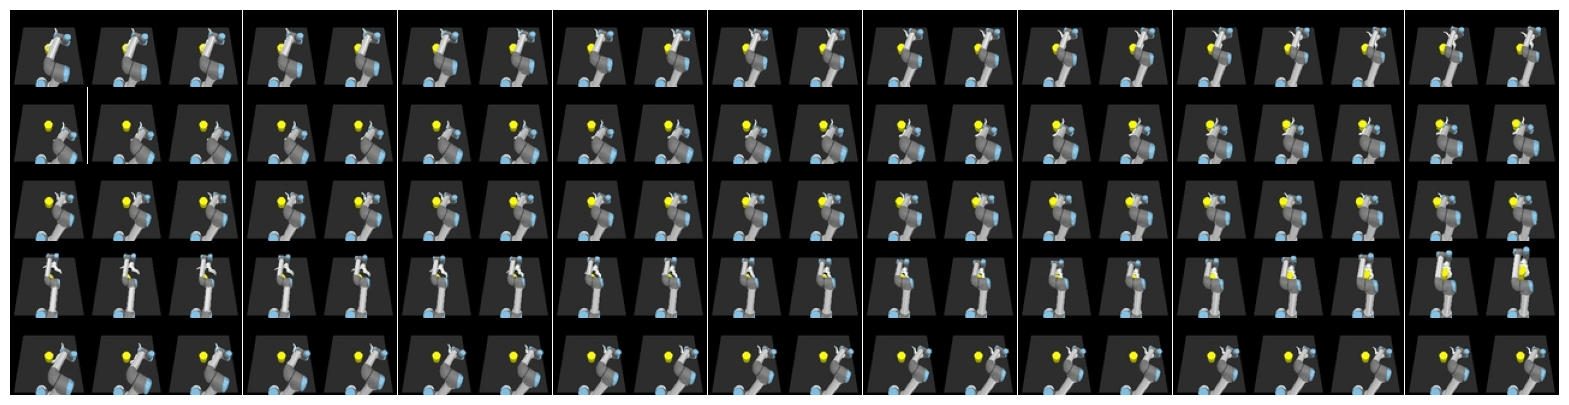

In [96]:
plot_model_result(gt_list, f'gt', num_frames = gt_list.shape[2], n = n)

#### VFP example, the last 10 frames are predicted by the model

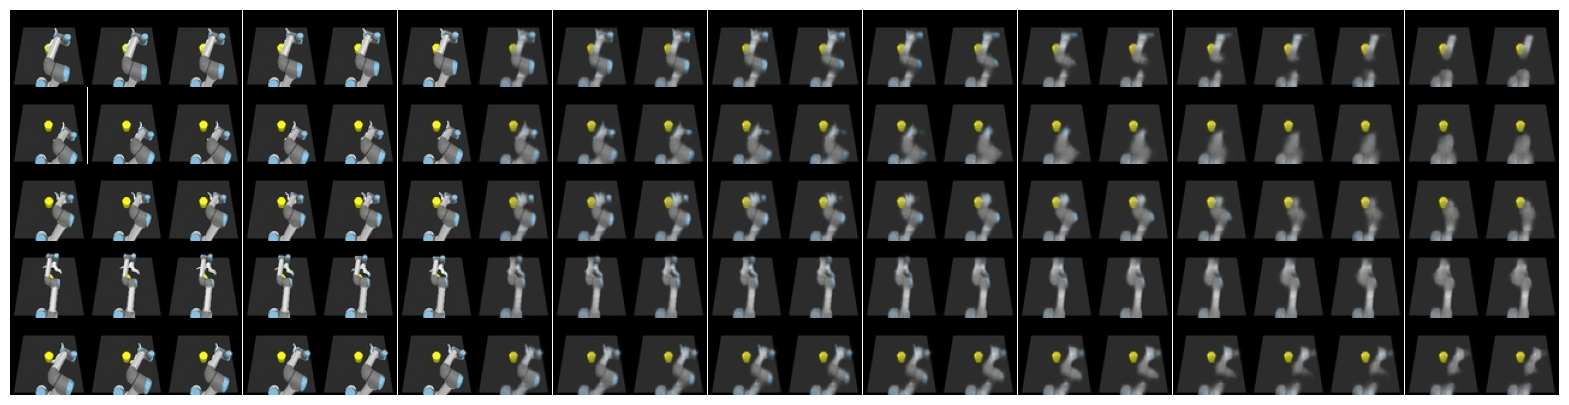

In [97]:
plot_model_result(vfp_list, f'vfp', num_frames = vfp_list.shape[2], n = n)

#### VPE example, the first 10 frames are generated by the model

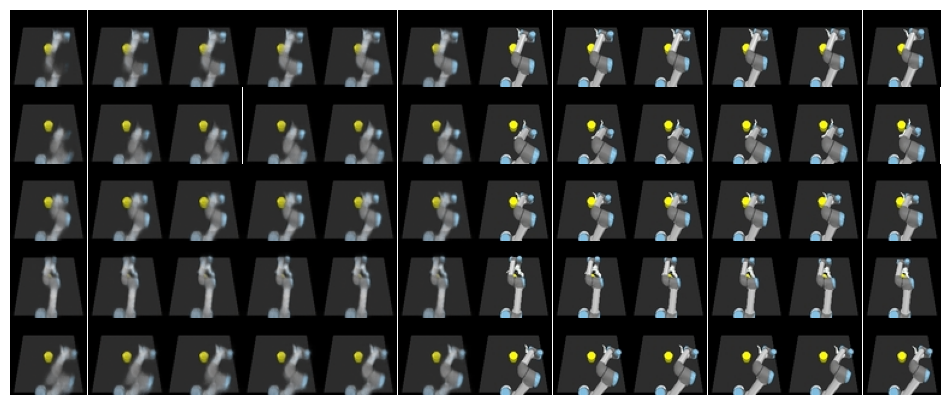

In [98]:
plot_model_result(vpe_list, f'vpe', num_frames = vpe_list.shape[2], n = n)

#### VFI example, the middle 8 frames are interpolated by the model

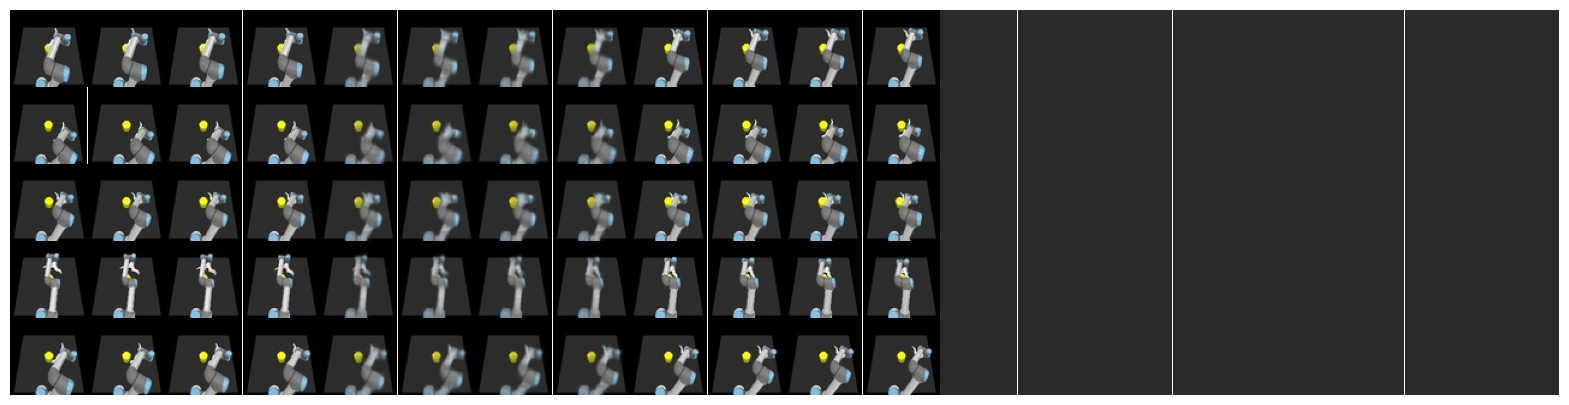

In [99]:
plot_model_result(vfi_list, f'vfi', num_frames = vfi_list.shape[2], n = n)

#### VRC example, generate any frame at the coordinates specified by tp_list
Here, tp_list = [4, 5, 8, 9, 11, 12, 13, 17, 18, 19]

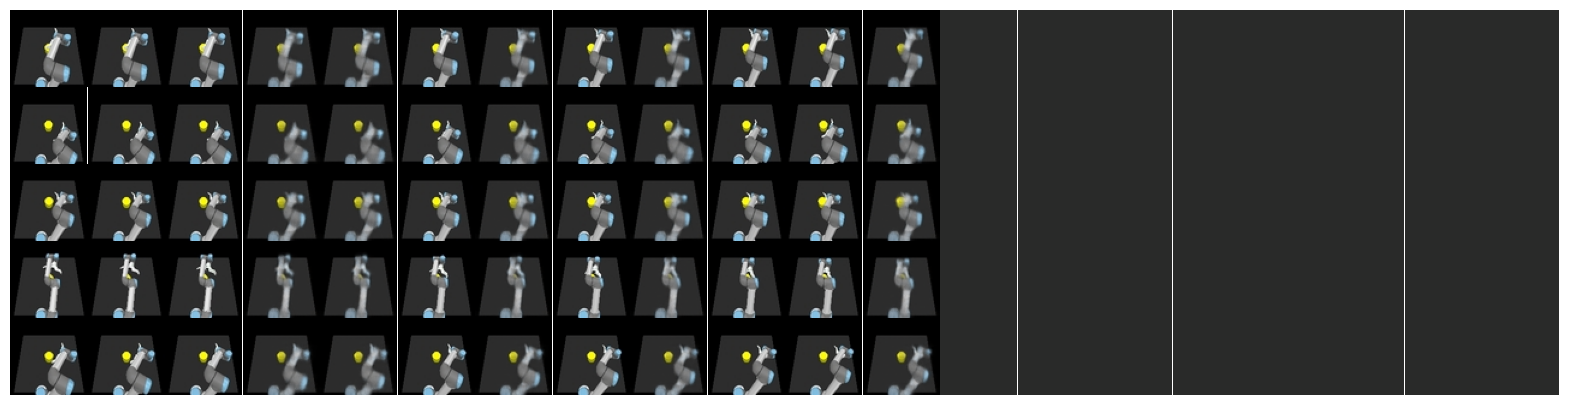

In [100]:
plot_model_result(vrc_list, f'vrc', num_frames = vrc_list.shape[2], n = n)

#### Continuous generation. Not only VRC, but also generate frames at the coordinates which do not exist in the training dataset
Here, tp_list = [4, 4.25, 4.5, 5, 5.25, 5.5, 5.75, 8, 8.5, 9, 9.5, 11, 11.5, 12, 12.5, 13, 13.5, 17, 17.25, 17.5, 18, 18.5, 19]. For example, "5.25, 5.5, 5.75" are real number coordinates which do not exist in the training dataset. 

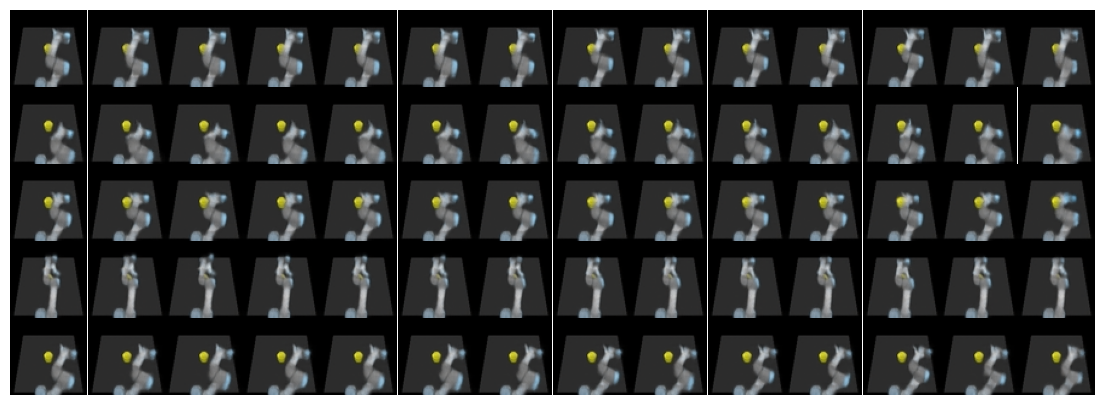

In [101]:
plot_model_result(vrc_hfps_list, f'continuous', num_frames = vrc_hfps_list.shape[2], n = n)

In short, we can give any real number coordinate as the target coordinate (tp_list), as long as it is smaller than the maximum coordinate (num_past_frames+num_future_frames - 1) used during training.

#### We can visualize the difference image between adjacent frames to show that they are different frome each other

In [102]:
vrc_hfps_shift_list = vrc_hfps_list[:, :, 1:, ...]
diff = (vrc_hfps_shift_list - vrc_hfps_list[:, :, 0:-1, ...]).abs()

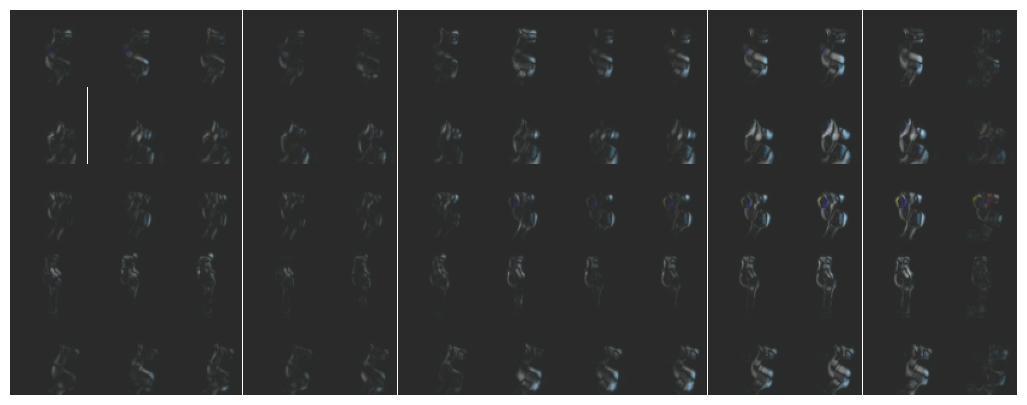

In [103]:
plot_model_result(diff, 'continuous diff', num_frames = diff.shape[2], n = n)